### Check if we have access to GPU

In [1]:
import torch
torch.cuda.is_available()

False

In [2]:
!pip install idx2numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7903 sha256=8cc1bed4136814bb988b7027214df00f057c61cda44af8a3fad5d50e4cb649ba
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


### Download the data and unzip

In [3]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -q
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -q
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -q
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -q

In [4]:
!gunzip t*-ubyte.gz

### Imports

In [5]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import LinearSegmentedColormap
import random

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

# <font color='cornflowerblue'>Convolution in action</font>

In [6]:
!wget https://akns-images.eonline.com/eol_images/Entire_Site/2022615/rs_1200x1200-220715105854-1200-Spongebob.jpg -q
!ls

rs_1200x1200-220715105854-1200-Spongebob.jpg  t10k-labels-idx1-ubyte
sample_data				      train-images-idx3-ubyte
t10k-images-idx3-ubyte			      train-labels-idx1-ubyte


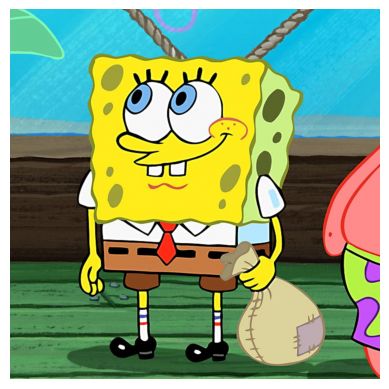

In [7]:
img = plt.imread('rs_1200x1200-220715105854-1200-Spongebob.jpg')/255.
plt.imshow(img)
_ = plt.axis('off')

In [8]:
img.shape

(1200, 1200, 3)

[<font color='red'>It's in the `NHWC` format</font>](https://). Let's convert it to `NCHW`

---



In [9]:
img_t = torch.FloatTensor(img)
img_t = img_t.permute(2, 0, 1)
img_t.shape

torch.Size([3, 1200, 1200])

Let's make a random kernel

### <font color='cornflowerblue'>`torch.nn.Conv2d(in_channels=, out_channels=, kernel_size=, stride=, padding=)`</font>

In [12]:
kernel  = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=7, stride=1, padding='same')
img_new = kernel(img_t)
img_new.shape

torch.Size([3, 1200, 1200])

Let's plot it

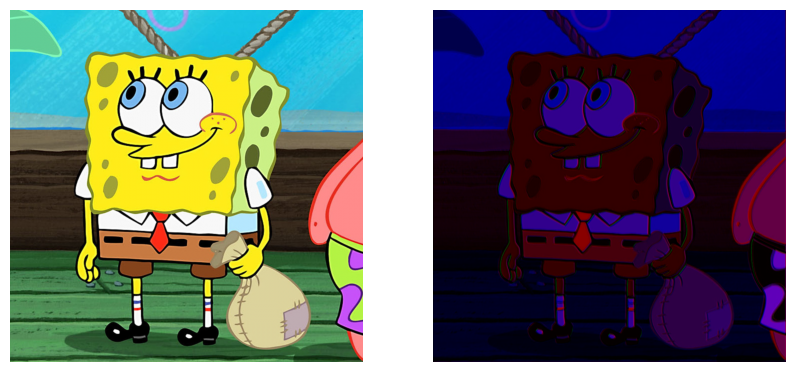

In [13]:
img_new = torch.clamp(img_new, min=0, max=1)
img_new = img_new.permute(1, 2, 0) # back to NHWC
img_new = img_new.detach().numpy()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.imshow(img)
_ = ax.axis('off')
ax = fig.add_subplot(122)
ax.imshow(img_new)
_ = ax.axis('off')

# <font color='cornflowerblue'>Pooling in action</font>

In [16]:
pool  = torch.nn.MaxPool2d(50, 50)
img_new = pool(img_t)
img_new.shape

torch.Size([3, 24, 24])

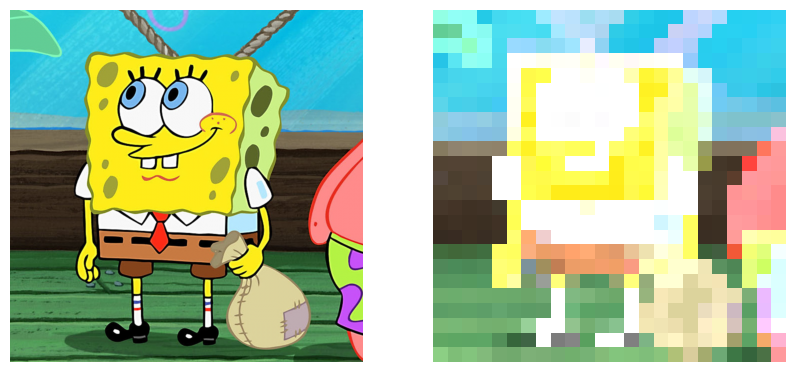

In [17]:
img_new = torch.clamp(img_new, min=0, max=1)
img_new = img_new.permute(1, 2, 0) # back to NHWC
img_new = img_new.detach().numpy()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.imshow(img)
_ = ax.axis('off')
ax = fig.add_subplot(122)
ax.imshow(img_new)
_ = ax.axis('off')

# How does the dataset look like?

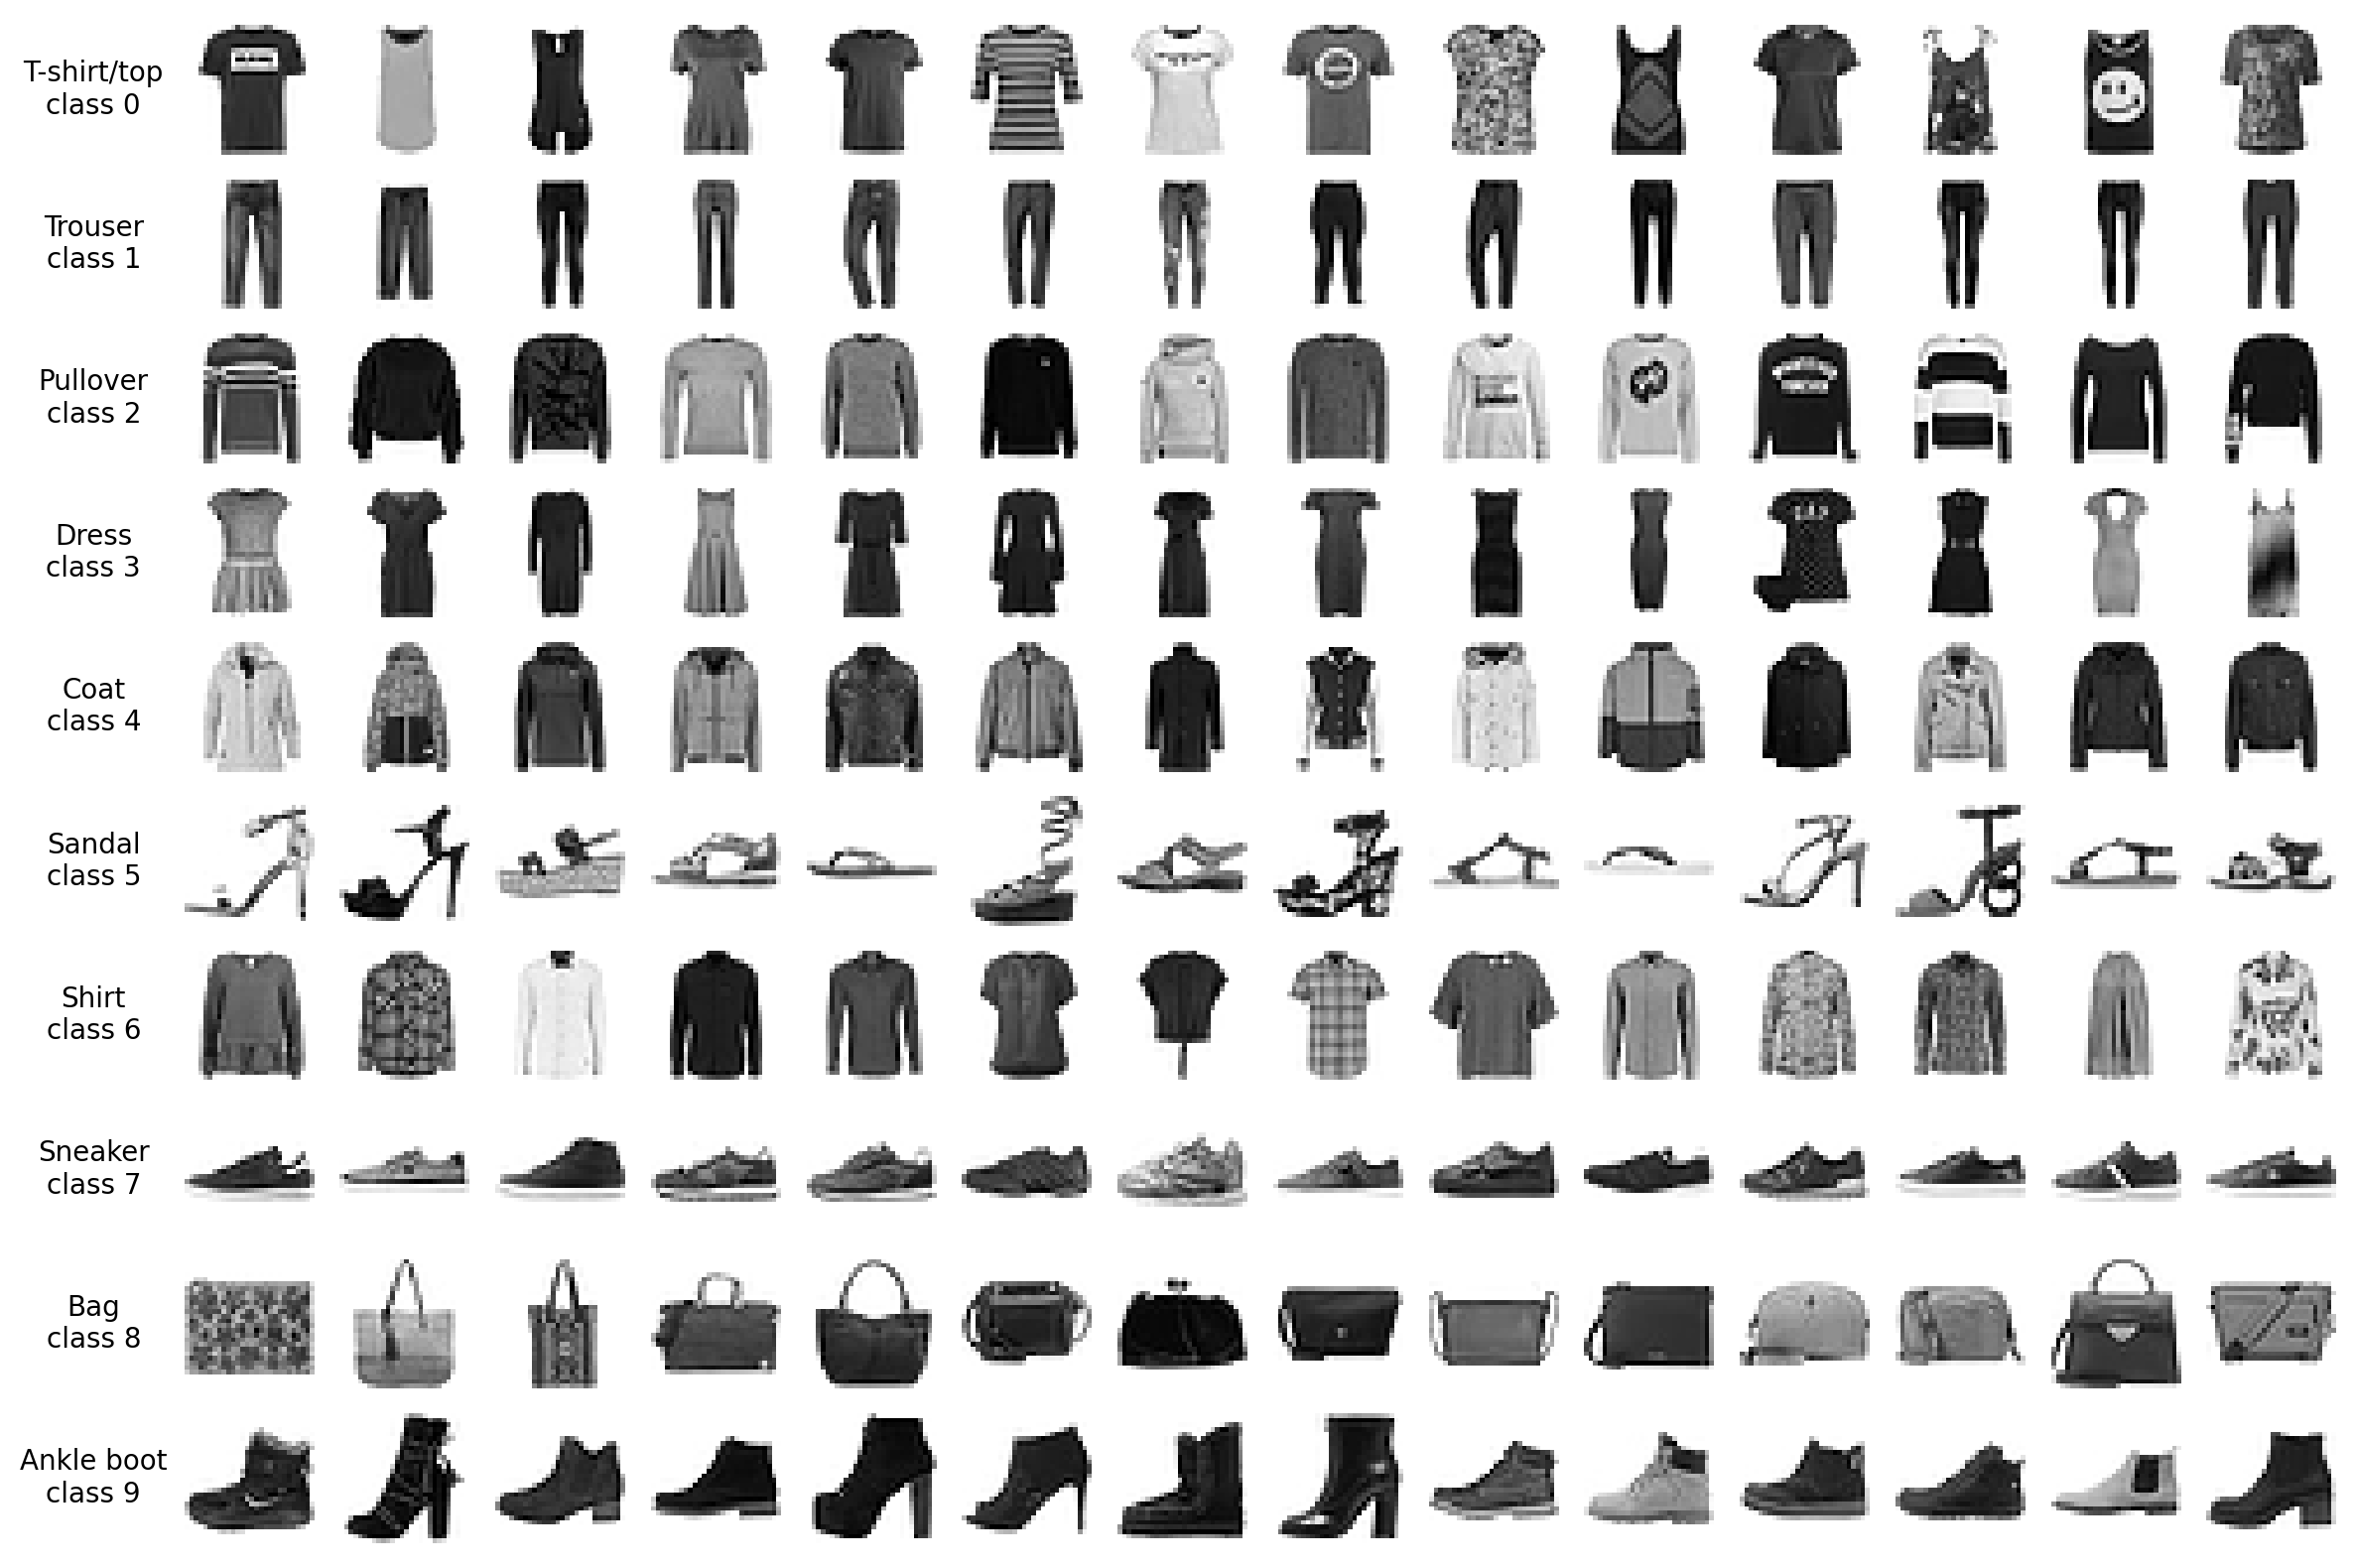

In [ ]:
imgs   = idx2numpy.convert_from_file('train-images-idx3-ubyte')
labels = idx2numpy.convert_from_file('train-labels-idx1-ubyte')

class_labels = "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"

fig = plt.figure(figsize=(15,10), dpi=200)

nrow, ncol = 10, 15
gs = GridSpec(nrow, ncol, hspace=0.1)

for cl_idx in range(10):
    
    idxs = np.where(labels==cl_idx)[0]
    ax = fig.add_subplot(gs[cl_idx*ncol])

    center_x = (ax.get_xlim()[1] - ax.get_xlim()[0]) / 2
    center_y = (ax.get_ylim()[1] - ax.get_ylim()[0]) / 2

    ax.text(center_x, center_y, class_labels[cl_idx] + f'\nclass {cl_idx}', ha='center', va='center')
    ax.axis("off")

    for j in range(1, ncol):
        ax = fig.add_subplot(gs[cl_idx*ncol + j])
        ax.imshow(imgs[idxs[j-1]], cmap='gray_r')
        ax.axis("off")

In [ ]:
fig = plt.figure(figsize=(16,9), dpi=200)

nrow, ncol = 18, 32
gs = GridSpec(nrow, ncol, hspace=0, wspace=0)

colors = ['slateblue', 'orangered', 'springgreen', 'tomato', 'violet', 'yellow', 'pink', 'lavender', 'cyan', 'lightskyblue']
img_idxs = random.sample(range(0, len(imgs) + 1), nrow*ncol)

for idx in range(nrow*ncol):

    ax = fig.add_subplot(gs[idx])
    
    img_idx   = img_idxs[idx]
    color_idx = labels[img_idx]

    color = colors[color_idx]
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['black', color])
    
    ax.imshow(imgs[img_idx], cmap=cmap)
    ax.axis("off")
fig.set_facecolor('k')


Output hidden; open in https://colab.research.google.com to view.

### Helper functions

In [18]:
def get_loss_accuracy(model, dataloader):
    losses = []
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for xb, yb in dataloader:
            if torch.cuda.is_available():
                xb = xb.cuda()
                yb = yb.cuda()
            ypred = model(xb)

            loss = nn.CrossEntropyLoss(reduction='none')(ypred, yb)
            losses.extend(loss.tolist())
            
            ypred = ypred.argmax(dim=1)
            correct_count += (ypred == yb).sum().item()
            total_count += ypred.size(0)

    return np.mean(losses), correct_count/total_count

### Datasets

In [19]:
class MyDataset(Dataset):
    def __init__(self, img_file, label_file):

        # load the images and the labels
        self.img_array   = idx2numpy.convert_from_file(img_file)
        self.label_array = idx2numpy.convert_from_file(label_file)

        # reshape image to NCHW
        self.img_array = self.img_array.reshape(-1, 1, 28, 28)

        # convert to tensor
        self.img_array   = torch.tensor(self.img_array).float()
        self.label_array = torch.tensor(self.label_array)

    def __len__(self):
        return len(self.label_array)

    def __getitem__(self, idx):
        img, label = self.img_array[idx], self.label_array[idx]
        return img, label

In [20]:
train_ds = MyDataset('train-images-idx3-ubyte', 'train-labels-idx1-ubyte')
val_ds   = MyDataset('t10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte')

In [21]:
len(train_ds), len(val_ds)

(60000, 10000)

### Dataloaders
# <font color='cornflowerblue'>New argument `num_workers`</font>

In [22]:
train_dl = DataLoader(train_ds, batch_size=500, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds, batch_size=5000, shuffle=False, num_workers=2)

### Let's build the network

In [27]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 8, 5)

        self.fc1 = nn.Linear(128, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [28]:
model = MyNN()

# put it on the GPU if it's available
if torch.cuda.is_available():
    model = model.cuda()

### Optimizer

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Training loop

In [30]:
train_losses = []; val_losses = []
train_accuracy = []; val_accuracy = []

for ep in tqdm(range(20)):
    for xb, yb in train_dl:

        # put them on the GPU if the GPU is available:
        if torch.cuda.is_available():
            xb = xb.cuda()
            yb = yb.cuda()

        # remove the previous gradeints
        optimizer.zero_grad()

        pred = model(xb)

        # compute loss
        loss = nn.CrossEntropyLoss()(pred, yb)

        # compute the gradients
        loss.backward()
        
        # update the network
        optimizer.step()

    # bookkeeping
    avg_loss, acc = get_loss_accuracy(model, train_dl)
    train_losses.append(avg_loss)
    train_accuracy.append(acc)

    avg_loss, acc = get_loss_accuracy(model, val_dl)
    val_losses.append(avg_loss)
    val_accuracy.append(acc)

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0, 0.5, 'accuracy')

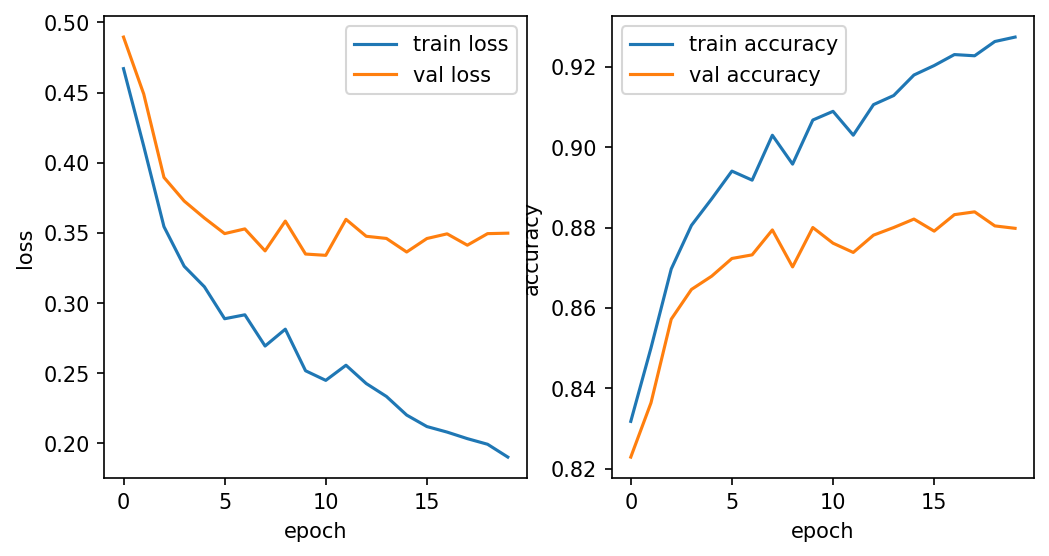

In [31]:
fig = plt.figure(figsize=(8,4), dpi=150)

ax = fig.add_subplot(121)
ax.plot(np.arange(len(train_losses)), train_losses, label='train loss')
ax.plot(np.arange(len(val_losses)), val_losses, label='val loss')
ax.legend()
ax.set_xlabel('epoch'); ax.set_ylabel('loss')

ax = fig.add_subplot(122)
ax.plot(np.arange(len(train_accuracy)), train_accuracy, label='train accuracy')
ax.plot(np.arange(len(val_accuracy)), val_accuracy, label='val accuracy')
ax.legend()
ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')

# Where it works and where it fails

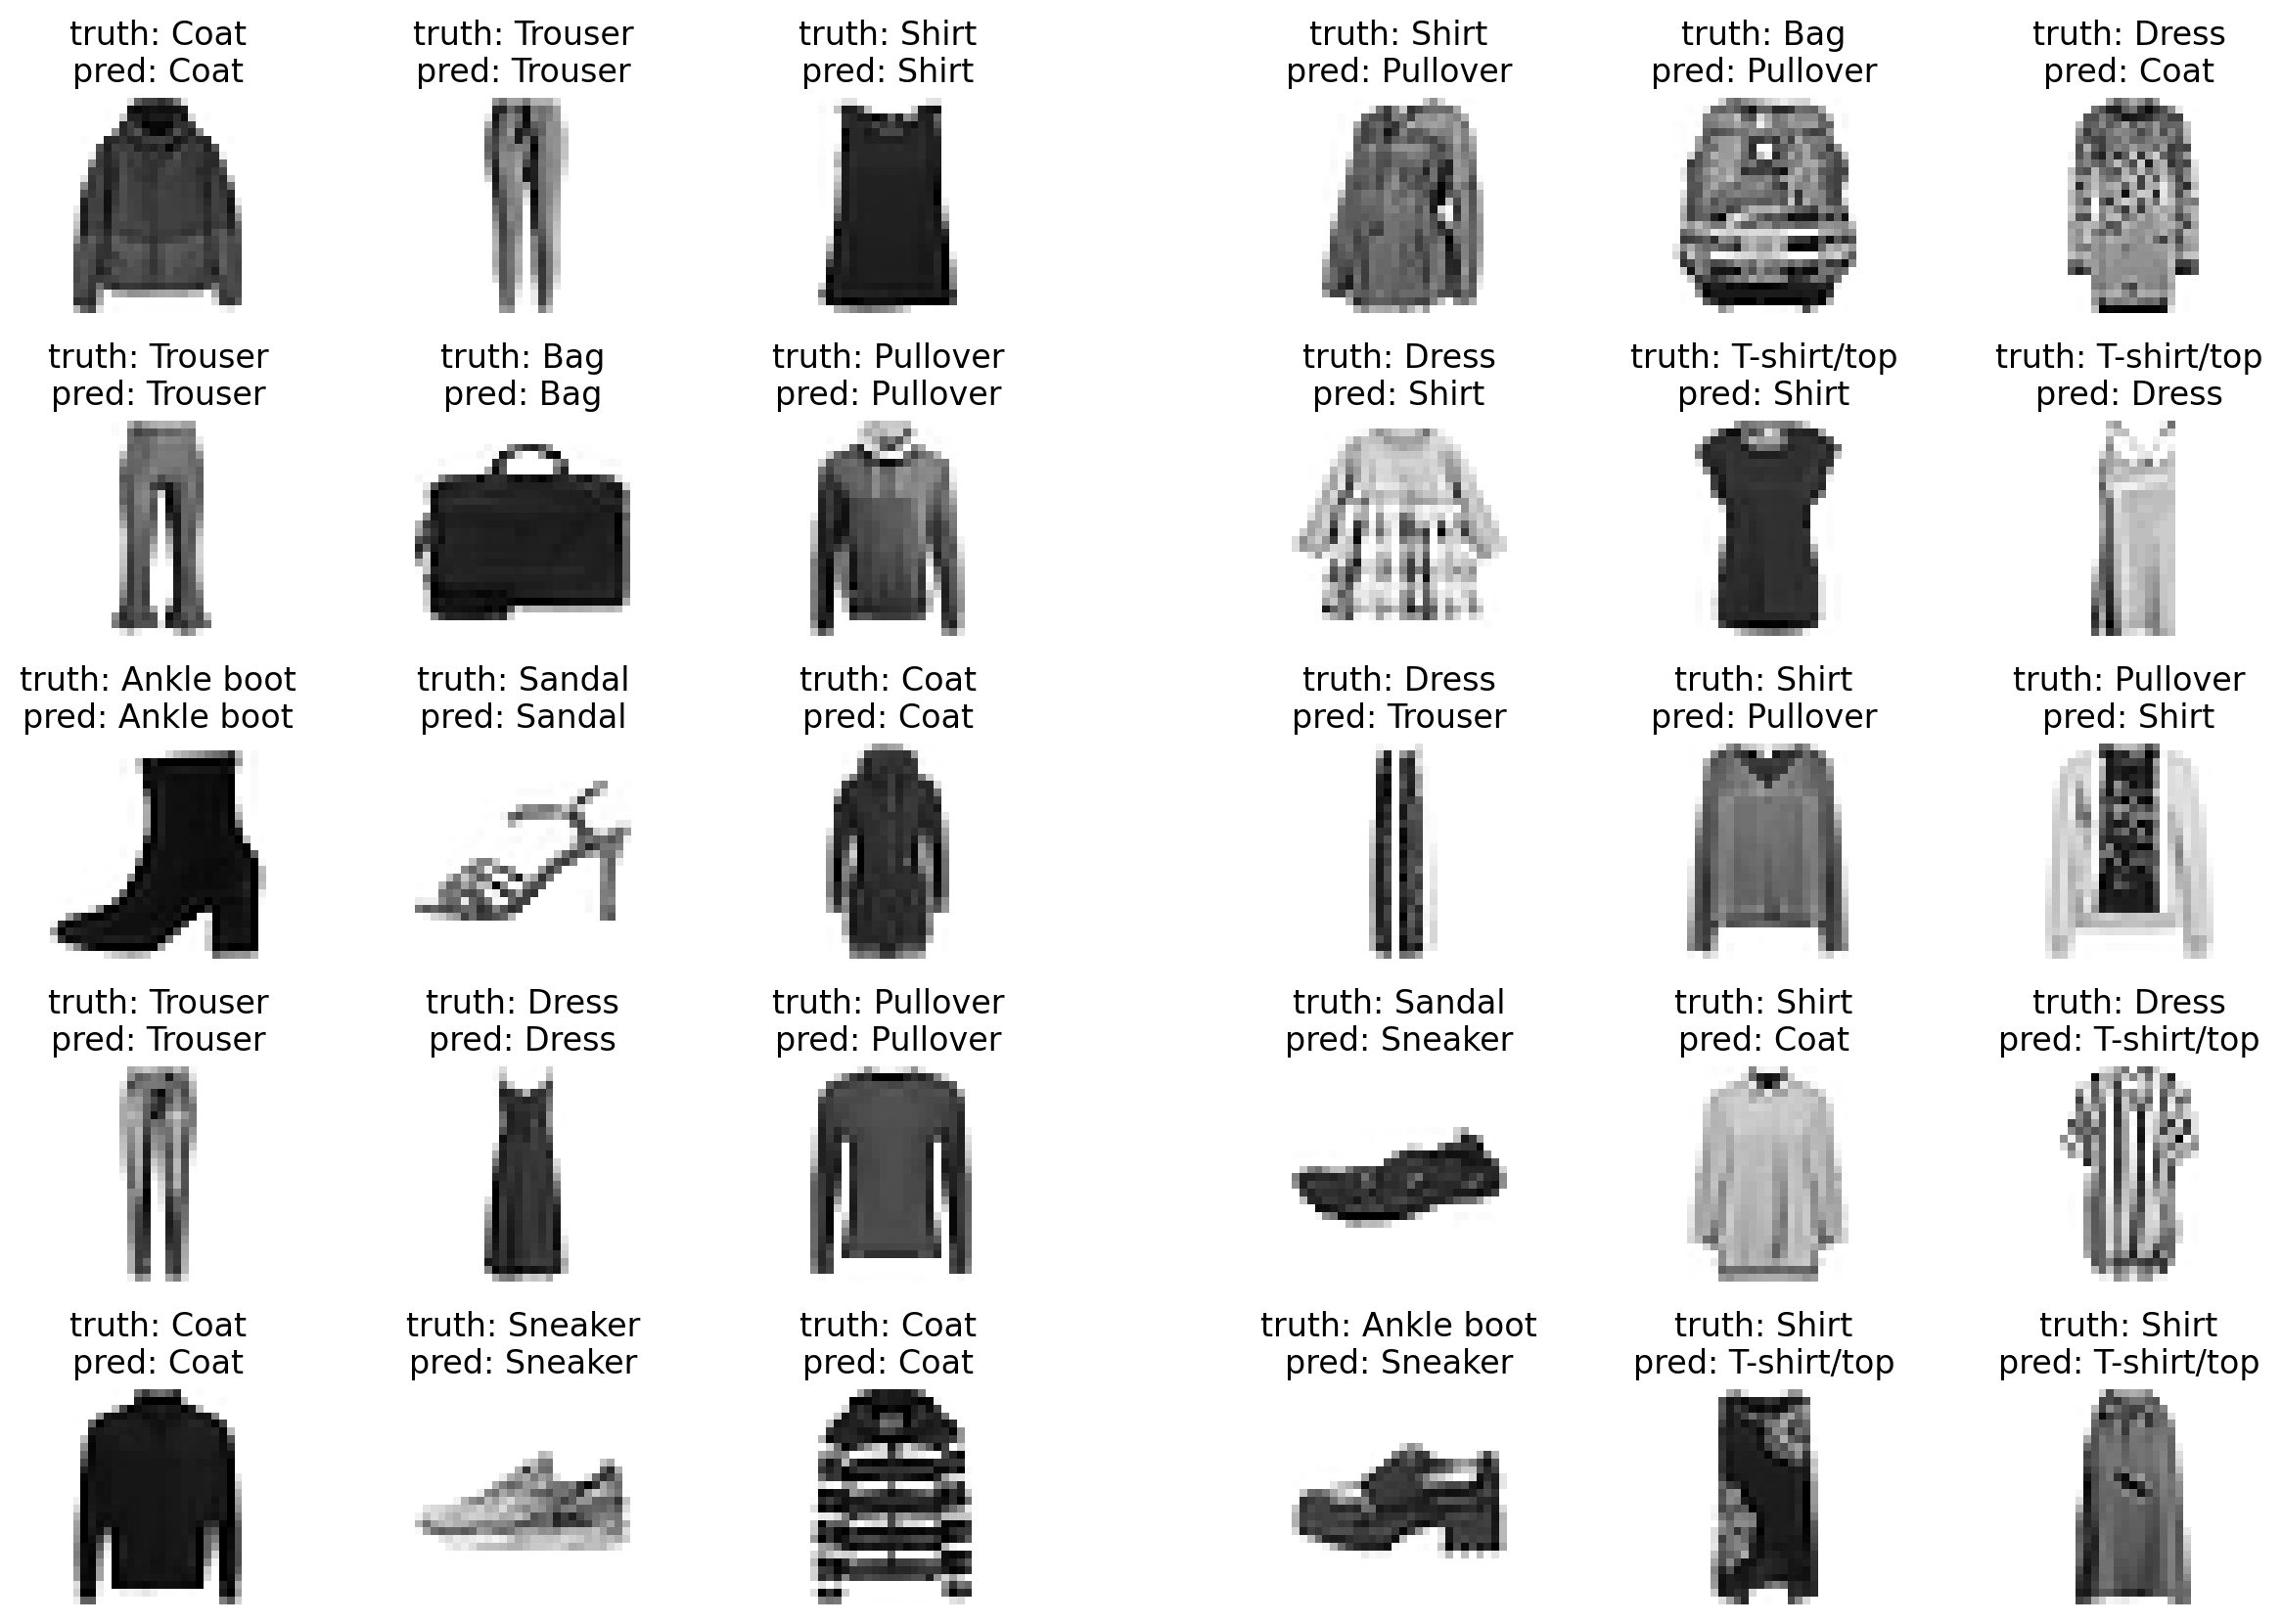

In [34]:
y_truths = []; y_preds = []

for xb, yb in val_dl:
    if torch.cuda.is_available():
        xb = xb.cuda()
    ypred = model(xb)
    ypred = ypred.argmax(dim=1)

    y_truths.extend(yb.tolist())
    y_preds.extend(ypred.tolist())

y_truths = np.array(y_truths)
y_preds = np.array(y_preds)

correct_idxs = np.where(y_truths == y_preds)[0]
wrong_idxs = np.where(y_truths != y_preds)[0]


class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

fig = plt.figure(figsize=(15,10), dpi=200)

nrow, ncol = 5, 3
gs = GridSpec(1, 2, wspace=0.2)

gs_ = GridSpecFromSubplotSpec(nrow, ncol, subplot_spec=gs[0], hspace=0.5)
idxs = random.choices(correct_idxs, k=nrow*ncol)

for i, idx in enumerate(idxs):
    ax = fig.add_subplot(gs_[i])
    ax.imshow(val_ds[idx][0][0], cmap='gray_r')
    ax.axis("off")

    t_cl = class_labels[y_truths[idx]]
    p_cl = class_labels[y_preds[idx]]
    title = f'truth: {t_cl}\npred: {p_cl}'
    ax.set_title(title)

gs_ = GridSpecFromSubplotSpec(nrow, ncol, subplot_spec=gs[1], hspace=0.5)
idxs = random.choices(wrong_idxs, k=nrow*ncol)

for i, idx in enumerate(idxs):
    ax = fig.add_subplot(gs_[i])
    ax.imshow(val_ds[idx][0][0], cmap='gray_r')
    ax.axis("off")

    t_cl = class_labels[y_truths[idx]]
    p_cl = class_labels[y_preds[idx]]
    title = f'truth: {t_cl}\npred: {p_cl}'
    ax.set_title(title)

<font color='cornflowerblue'>**Mistakes are reasonable!**</font>